In [3]:
import json

# Replace with your actual credentials
kaggle_token = {
    "username": "favourodiyo",
    "key": "KGAT_2aabdc1e6472822488b90563cde36f6b"
}

# Save to kaggle.json
with open("kaggle.json", "w") as file:
    json.dump(kaggle_token, file)

# Set up the API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d wordsforthewise/lending-club


Dataset URL: https://www.kaggle.com/datasets/wordsforthewise/lending-club
License(s): CC0-1.0
 99% 1.25G/1.26G [00:07<00:00, 121MB/s] 
100% 1.26G/1.26G [00:07<00:00, 170MB/s]


In [5]:
import zipfile

with zipfile.ZipFile("lending-club.zip", 'r') as zip_ref:
    zip_ref.extractall("lending_club_data")


In [1]:
import pandas as pd


accepted_df = pd.read_csv("lending_club_data/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv", low_memory=False)

# accepted_df.sample(5)


In [2]:
# Use a copy of the original
df = accepted_df.copy()

# Convert issue date to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

# Check loan_status unique values
print(df['loan_status'].value_counts())


loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64


In [5]:
# Mapping original loan_status to our simplified target labels
status_mapping = {
    'Fully Paid': 'Performing',
    'Current': 'Performing',
    'Late (16-30 days)': 'Non-performing',
    'In Grace Period': 'Non-performing',
    'Late (31-120 days)': 'Non-performing',
    'Charged Off': 'Defaulted',
    'Default': 'Defaulted'
}

# Apply the mapping
df = accepted_df.copy()
df['loan_performance'] = df['loan_status'].map(status_mapping)

# Drop rows that did not match the mapping (e.g., "Does not meet credit policy")
df = df[df['loan_performance'].notnull()]

# Check the cleaned result
df['loan_performance'].value_counts()


,count
loan_performance,
Performing,1955068
Defaulted,268599
Non-performing,34252


In [6]:
# Drop columns where more than 60% of values are missing
threshold = 0.6
df_clean = df.loc[:, df.isnull().mean() < threshold]

print(f"Columns remaining after dropping mostly-empty ones: {df_clean.shape[1]}")


Columns remaining after dropping mostly-empty ones: 110


In [7]:
# Manually drop unneeded columns
columns_to_drop = [
    'id', 'member_id', 'url', 'desc', 'title',
    'zip_code', 'addr_state', 'policy_code', 'application_type',
    'pymnt_plan', 'loan_status',  # we already mapped it
]

df_clean.drop(columns=[col for col in columns_to_drop if col in df_clean.columns], inplace=True)


/tmp/ipython-input-476259044.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(columns=[col for col in columns_to_drop if col in df_clean.columns], inplace=True)


In [9]:
df_clean['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')


/tmp/ipython-input-908473326.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')


In [10]:
df_clean.shape

(2257919, 101)

In [11]:
# Save the cleaned DataFrame to a Parquet file
df_clean.to_parquet('lending_club_cleaned.parquet', index=False)
print("df_clean saved to 'lending_club_cleaned.parquet'")

df_clean saved to 'lending_club_cleaned.parquet'


You can load the saved DataFrame back into a new DataFrame like this:

In [1]:
# Load the cleaned DataFrame from the Parquet file
import pandas as pd
n_df = pd.read_parquet('lending_club_cleaned.parquet')
print("Loaded DataFrame shape:", n_df.shape)
display(n_df.head())

Loaded DataFrame shape: (2257919, 101)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,loan_performance
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,...,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N,Performing
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,...,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N,Performing
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,...,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N,Performing
3,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,...,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N,Performing
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,...,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N,Performing


In [3]:
import matplotlib.pyplot as plt


# Group by issue date (monthly)
monthly_issued = n_df.groupby(n_df['issue_d'].dt.to_period("M")).size()

# Plot
monthly_issued.plot(kind='line', figsize=(12, 6), title='📈 Customer Acquisition Over Time')
plt.xlabel("Issue Date")
plt.ylabel("Number of Loans Issued")
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'n_df' is not defined

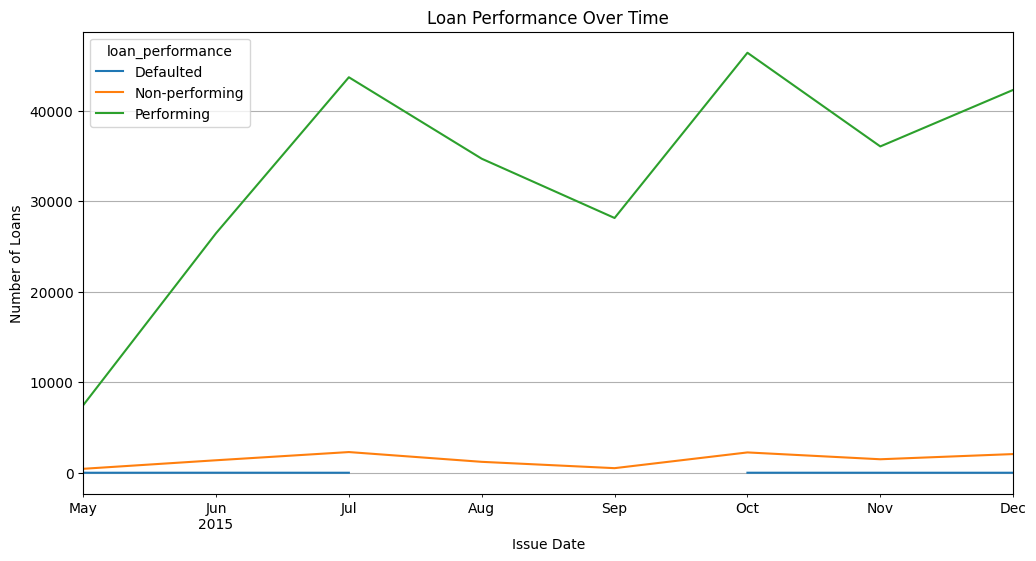

In [ ]:
# Group by issue date and loan_performance
performance_trend = n_df.groupby([n_df['issue_d'].dt.to_period("M"), 'loan_performance']).size().unstack()

# Plot
performance_trend.plot(kind='line', figsize=(12,6), title="Loan Performance Over Time")
plt.xlabel("Issue Date")
plt.ylabel("Number of Loans")
plt.grid(True)
plt.show()


In [3]:
features = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
            'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti', 'fico_range_high']


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
n_df['loan_performance'].value_counts()

,count
loan_performance,
Performing,265089
Non-performing,11611
Defaulted,14


In [5]:
# Keep only selected columns + target
model_df = n_df[features + ['loan_performance']]

# Encode categorical columns
for col in model_df.select_dtypes(include='object').columns:
    model_df[col] = LabelEncoder().fit_transform(model_df[col])


/tmp/ipython-input-4207559810.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[col] = LabelEncoder().fit_transform(model_df[col])
/tmp/ipython-input-4207559810.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[col] = LabelEncoder().fit_transform(model_df[col])
/tmp/ipython-input-4207559810.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [6]:
# Split
X = model_df.drop('loan_performance', axis=1)
y = model_df['loan_performance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify =y, random_state=42)

In [ ]:
print(y.value_counts())


loan_performance
2    265089
1     11611
0        14
Name: count, dtype: int64


In [ ]:
# Train
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [ ]:
# Predict
y_pred = model.predict(X_test)

# Results
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[    0     0     2]
 [    0     1  2293]
 [    0     0 53047]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.00      0.00      2294
           2       0.96      1.00      0.98     53047

    accuracy                           0.96     55343
   macro avg       0.65      0.33      0.33     55343
weighted avg       0.96      0.96      0.94     55343



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Trying to downsample the larger class

In [ ]:
from sklearn.utils import resample

# Combine features and target for easy sampling
train_df = X_train.copy()
train_df['loan_performance'] = y_train

# Separate by class
performing = train_df[train_df['loan_performance'] == 2]
non_performing = train_df[train_df['loan_performance'] == 1]
defaulted = train_df[train_df['loan_performance'] == 0]

# Downsample the performing class to match non-performing or defaulted
performing_downsampled = resample(
    performing,
    replace=False,
    n_samples=non_performing.shape[0],  # or defaulted.shape[0]
    random_state=42
)

# Combine into balanced training set
train_balanced = pd.concat([performing_downsampled, non_performing, defaulted])

# Shuffle the training set
train_balanced = train_balanced.sample(frac=1, random_state=42)

# Split into features and labels
X_train_bal = train_balanced.drop('loan_performance', axis=1)
y_train_bal = train_balanced['loan_performance']


In [ ]:

# Train on balanced data
model = RandomForestClassifier(random_state=42)
model.fit(X_train_bal, y_train_bal)

# Predict on original test set
y_pred = model.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[    0     2     1]
 [    0  1479   843]
 [    0 22737 30281]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.06      0.64      0.11      2322
           2       0.97      0.57      0.72     53018

    accuracy                           0.57     55343
   macro avg       0.34      0.40      0.28     55343
weighted avg       0.93      0.57      0.69     55343



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score


In [ ]:
# Initialize model with class imbalance handling
model = XGBClassifier(
    objective='multi:softmax',  # For classification
    num_class=3,                # 3 classes: Defaulted, Non-performing, Performing
    eval_metric='mlogloss',     # Multi-class log loss
    use_label_encoder=False,
    scale_pos_weight=5,         # Helps with imbalance (tune later if needed)
    random_state=42
)

# Train model
model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:32:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3, ...)

In [ ]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

# Optional: Macro F1 score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", macro_f1)


[[    0     0     3]
 [    0     0  2322]
 [    0     2 53016]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         3
           1     0.0000    0.0000    0.0000      2322
           2     0.9580    1.0000    0.9785     53018

    accuracy                         0.9580     55343
   macro avg     0.3193    0.3333    0.3262     55343
weighted avg     0.9177    0.9580    0.9374     55343

Macro F1 Score: 0.3261750293007503


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


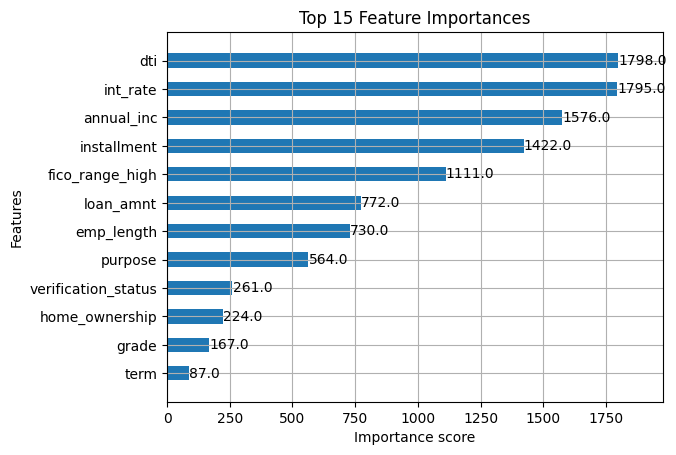

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_importance(model, max_num_features=15, height=0.5)
plt.title("Top 15 Feature Importances")
plt.show()


In [11]:
features = selected_features = [
    'loan_amnt',
    'term',
    'int_rate',
    'installment',
    'grade',
    'sub_grade',
    'emp_length',
    'home_ownership',
    'annual_inc',
    'verification_status',
    'purpose',
    'dti',
    'fico_range_low',
    'fico_range_high',
    'total_rec_prncp',
    'total_rec_int',
    'recoveries',
    'collection_recovery_fee',
    'last_pymnt_amnt',
    'out_prncp',
    'out_prncp_inv'
]


In [20]:
# Keep only selected columns + target
xg_df = n_df[features + ['loan_performance']]

# Encode categorical columns
for col in xg_df.select_dtypes(include='object').columns:
    xg_df[col] = LabelEncoder().fit_transform(xg_df[col])

/tmp/ipython-input-1223788449.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xg_df[col] = LabelEncoder().fit_transform(xg_df[col])
/tmp/ipython-input-1223788449.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xg_df[col] = LabelEncoder().fit_transform(xg_df[col])
/tmp/ipython-input-1223788449.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [21]:
# Split
X = xg_df.drop('loan_performance', axis=1)
y = xg_df['loan_performance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify =y, random_state=42)

In [22]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get weights for each class
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Turn into dict {class: weight}
class_weights = {i : weights[i] for i in range(len(weights))}
print("Class weights:", class_weights)


Class weights: {0: np.float64(2.8020963736180207), 1: np.float64(21.973274456852298), 2: np.float64(0.3849685923035053)}


In [23]:
model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=1,  # Reset this
    random_state=42,
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8
)

# Set sample weights manually
sample_weights = y_train.map(class_weights)

# Train
model.fit(X_train, y_train, sample_weight=sample_weights)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:15:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=3, ...)

In [24]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
print("F1 Macro:", f1_score(y_test, y_pred, average='macro'))


F1 Macro: 0.6337497630788261


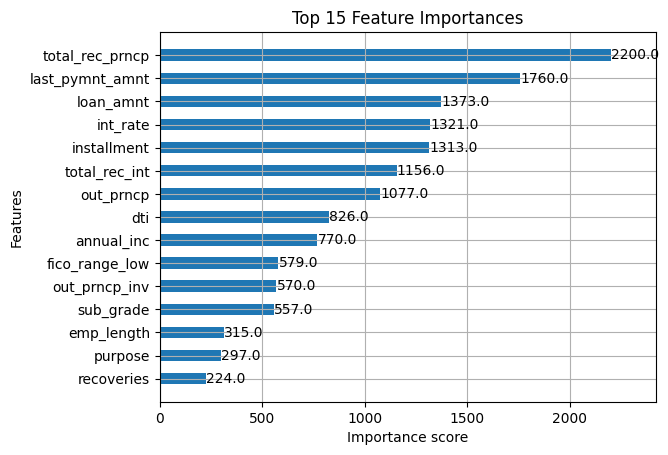

In [25]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=15, height=0.5)
plt.title("Top 15 Feature Importances")
plt.show()


In [27]:
xg_df.to_csv("loan_model_cleaned.csv", index=False)


# Trying SMOTE


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE on training data only
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [ ]:
# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)


KeyboardInterrupt: 

In [ ]:
# Predict
y_pred = model.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
